In [11]:
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import json
import joblib

In [3]:
# Load data
file_path = os.path.join("data","processed_data.csv")

df = pd.read_csv(file_path)  

print(len(df))
df.head()

X=df.drop(columns=['Response Time', 'Latency', 'Service Name_0', 'Service Name_1', 'Service Name_2', 'Service Name_3', 'Compliance', 'Class', 'WsRF'])
Y=df['Response Time']


X_rest, X_test, y_rest, y_test = train_test_split(
    X, Y, test_size=0.15, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_rest, y_rest, test_size=0.53, random_state=42
)

364


In [4]:
# Load Ridge model
final_model = joblib.load("saved_models/best_reg_model.pkl")

final_model.fit(X_rest, y_rest)
y_pred = final_model.predict(X_test)

In [5]:
# Evaluation metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Test R²: {r2:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")

Test R²: 0.4115
Test RMSE: 882.6912
Test MAE: 407.4162


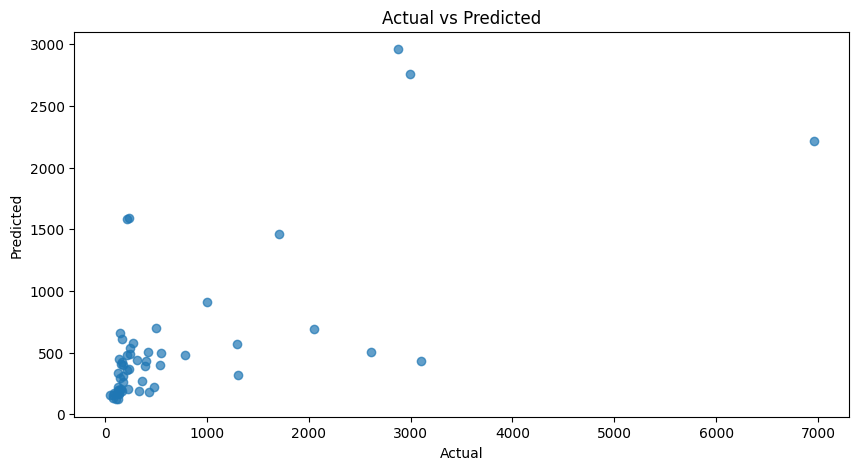

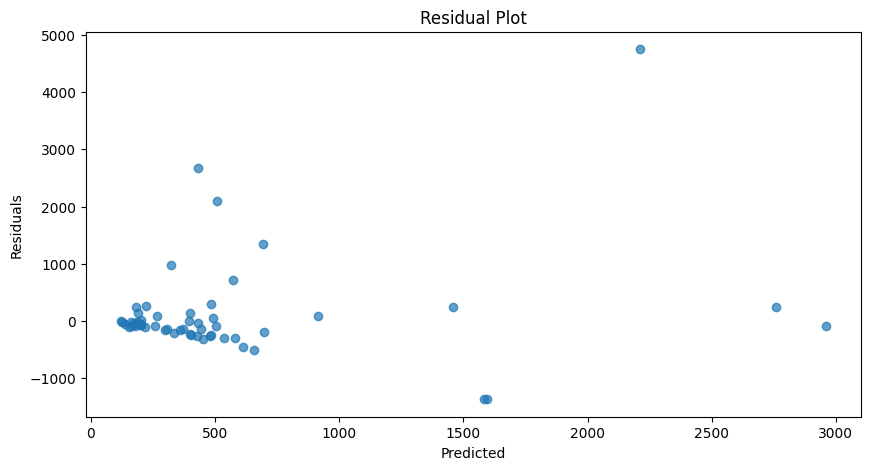

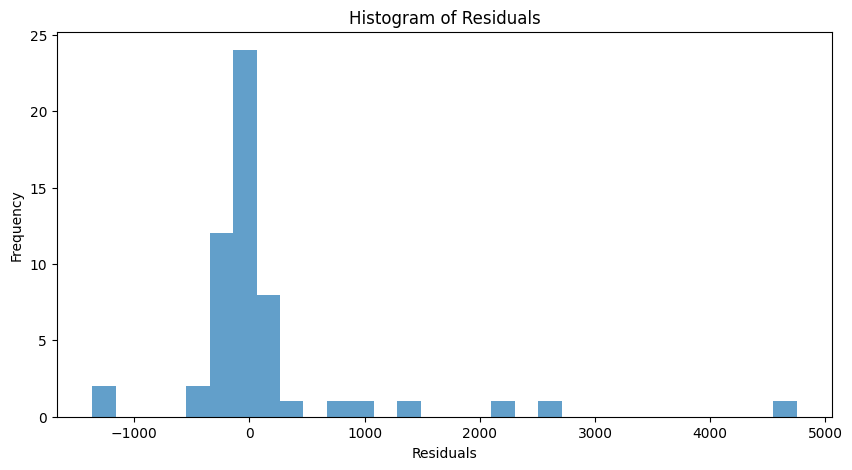

In [6]:
# Calculate residuals
residuals = y_test - y_pred

# 1. Actual vs Predicted
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()

# 2. Residual plot
plt.figure(figsize=(10, 5))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

# 3. Histogram of residuals
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=30, alpha=0.7)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

# Save metadata as JSON
#with open(os.path.join(output_dir, "plots_info.json"), "w") as f:
#    json.dump(plot_info, f, indent=4)

In [13]:
numeric_features = ['Availability', 'Throughput', 'Successability',
                    'Reliability', 'Best Practices', 'Documentation']


def winsorize(X):
    df_num = pd.DataFrame(X, columns=numeric_features)
    for col in numeric_features:
        if df_num[col].notna().sum() > 0: 
            lower = df_num[col].quantile(0.25)
            upper = df_num[col].quantile(0.75)
            df_num[col] = np.clip(df_num[col], lower, upper)
    return df_num

winsorizer = FunctionTransformer(winsorize, validate=False)

numeric_transformer = Pipeline(steps=[
    ("winsorizer", winsorizer),
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features)
], remainder='drop')  

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", final_model)  
])


def save_model_package(base_path, model_name, pipeline, metrics, feature_names, data_info,
                       X_train=None, X_test=None, y_train=None, y_test=None):
    """
    Saves:
    - Model
    - Metrics (JSON + CSV)
    - Model Card
    - Splits (optional)
    """
    path = os.path.join(base_path, model_name)
    os.makedirs(path, exist_ok=True)

    # Save model
    joblib.dump(pipeline, os.path.join(path, 'pipeline_model.pkl'))

    # Save metrics
    with open(os.path.join(path, 'metrics.json'), 'w') as f:
        json.dump(metrics, f, indent=4)
    pd.DataFrame([metrics]).to_csv(os.path.join(path, 'metrics.csv'), index=False)

    # Create model card
    with open(os.path.join(path, 'model_card.md'), 'w') as f:
        f.write(f"""
            # Model Card: {model_name}

            ## Data
            Source: {data_info.get('source')}
            Size: {data_info.get('size')}

            ## Features
            {', '.join(feature_names)}

            ## Metrics
            {json.dumps(metrics, indent=4)}
            """)

    # Save splits if provided
    if X_rest is not None and X_test is not None:
        joblib.dump(X_rest, os.path.join(path, 'X_rest.pkl'))
        joblib.dump(X_test, os.path.join(path, 'X_test.pkl'))
    if y_rest is not None and y_test is not None:
        joblib.dump(y_rest, os.path.join(path, 'y_rest.pkl'))
        joblib.dump(y_test, os.path.join(path, 'y_test.pkl'))

    print(f"Model package saved at: {path}")

# Metrics
metrics = {
    "MAE": mean_absolute_error(y_test, y_pred),
    "MSE": mean_squared_error(y_test, y_pred),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
    "R2": r2_score(y_test, y_pred)
}

# Info for model card
data_info = {"source": "qws1/data.csv", "size": len(df)}
feature_names = numeric_features

# Save everything
save_model_package('regression_package', 'best_model', pipeline, metrics, feature_names, data_info,
                   X_train=X_rest, X_test=X_test, y_train=y_rest, y_test=y_test)

Model package saved at: regression_package\best_model
